In [ ]:
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda:0


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)

        x = self.classifier(x)

        return x

In [ ]:
def train_model(model, device, train_loader, val_loader, test_loader, num_epochs, optimizer, patience):
    start_time = time.time()

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    counter = 0
    best_val_loss = 0

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_correct = 0

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)
            loss = F.cross_entropy(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            running_correct += (predicted_labels == targets).sum().item()

            if not batch_idx % 50:
                print(f"Epoch: {epoch+1:02d}/{num_epochs:02d} | Mini-Batch {batch_idx:03d}/{len(train_loader):03d} | Loss: {loss:.4f}")

        train_loss = running_loss / len(train_loader)
        train_acc = running_correct / len(train_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()

        with torch.no_grad():
            val_loss, correct_preds, num_examples = 0., 0, 0

            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.to(device)

                outputs = model(features)

                loss = F.cross_entropy(outputs, targets, reduction='sum')

                val_loss += loss

                _, predicted_labels = torch.max(outputs, 1)

                correct_preds += (predicted_labels == targets).sum()

                num_examples += targets.size(0)

            val_loss = val_loss / num_examples

            val_acc = correct_preds.float() / num_examples * 100

            print(f"\nVal Loss: {val_loss:.3f} | Val Accuracy: {val_acc:.3f}\n")

            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if not best_val_loss or val_loss < best_val_loss:
                best_val_loss = val_loss

                counter = 0

            else:
                counter += 1

                if counter == patience:
                    print(f"Early stopping at epoch {epoch + 1}!")

                    break


        print(f"Time elapsed: {((time.time() - start_time) / 60):.2f} min\n\n")

    print(f"Total Training Time: {((time.time() - start_time) / 60):.2f} min\n")

    model.eval()

    with torch.no_grad():
        correct_preds, num_examples = 0, 0

        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)

            _, predicted_labels = torch.max(outputs, 1)

            correct_preds += (predicted_labels == targets).sum()

            num_examples += targets.size(0)

        test_acc = correct_preds.float() / num_examples * 100

        print(f"Test accuracy: {test_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
num_classes = 10
learning_rate = 0.001
num_epochs = 10
mini_batch_size = 72
patience = 5

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)

train_size = int(0.98 * len(dataset))
val_size = int(0.01 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=mini_batch_size,
                                          shuffle=True,
                                          num_workers=2,)

val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size=mini_batch_size,
                                        shuffle=False,
                                        num_workers=2,)

test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size=mini_batch_size,
                                         shuffle=False,
                                         num_workers=2,)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)

    break

100%|██████████| 170498071/170498071 [00:03<00:00, 49686419.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Image batch dimensions: torch.Size([72, 3, 224, 224])
Image label dimensions: torch.Size([72])


In [ ]:
model = VGG16()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

train_losses, val_losses, train_accs, val_accs = train_model(model, device, train_loader, val_loader, test_loader, num_epochs, optimizer, patience)

Epoch: 01/10 | Mini-Batch 000/681 | Loss: 2.3005
Epoch: 01/10 | Mini-Batch 050/681 | Loss: 2.3049
Epoch: 01/10 | Mini-Batch 100/681 | Loss: 2.2915
Epoch: 01/10 | Mini-Batch 150/681 | Loss: 2.1248
Epoch: 01/10 | Mini-Batch 200/681 | Loss: 2.0404
Epoch: 01/10 | Mini-Batch 250/681 | Loss: 2.0891
Epoch: 01/10 | Mini-Batch 300/681 | Loss: 1.7579
Epoch: 01/10 | Mini-Batch 350/681 | Loss: 1.8355
Epoch: 01/10 | Mini-Batch 400/681 | Loss: 1.6251
Epoch: 01/10 | Mini-Batch 450/681 | Loss: 1.6645
Epoch: 01/10 | Mini-Batch 500/681 | Loss: 1.4874
Epoch: 01/10 | Mini-Batch 550/681 | Loss: 1.6085
Epoch: 01/10 | Mini-Batch 600/681 | Loss: 1.5374
Epoch: 01/10 | Mini-Batch 650/681 | Loss: 1.6460

Val Loss: 1.587 | Val Accuracy: 41.800

Time elapsed: 11.34 min


Epoch: 02/10 | Mini-Batch 000/681 | Loss: 1.5484
Epoch: 02/10 | Mini-Batch 050/681 | Loss: 1.6738
Epoch: 02/10 | Mini-Batch 100/681 | Loss: 1.1943
Epoch: 02/10 | Mini-Batch 150/681 | Loss: 1.3061
Epoch: 02/10 | Mini-Batch 200/681 | Loss: 1.3253
Ep

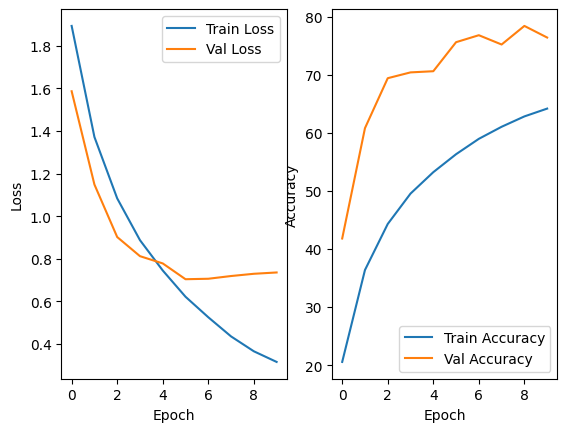

In [ ]:
val_losses_cpu = torch.Tensor(val_losses).to('cpu')
val_accs_cpu = torch.Tensor(val_accs).to('cpu')


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses_cpu, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs_cpu, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()